In [12]:
import pandas as pd
from torchvision import transforms
import torchvision
import torchsummary
import numpy as np
from code.diganes_dataset import DiganesDataset
from code.MyPytorchModel import MyPytorchModel
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


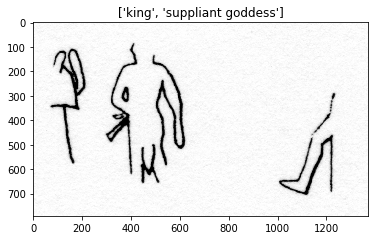

In [13]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=250)

image, labels = diganes[222]
diganes.show_image(image, labels)

In [21]:
image_size = 224

transform = transforms.Compose(
    [transforms.Resize((image_size, image_size)), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.49191375, 0.48235852, 0.44673872], 
                          std=[0.24706447, 0.24346213, 0.26147554])])

dataset = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=250, transform=transform)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [7200, 1000, 1124])

dataset = (train_set, val_set, test_set,)

In [22]:
# We first load the model and have a look at the different parts of the network

# load the pretrained model
pretrained_model = torchvision.models.mobilenet_v2(pretrained=True)

# features
print('Conv feature extractor:')
print(pretrained_model.features)
# classifier
print('Classification head:')
print(pretrained_model.classifier)

Conv feature extractor:
Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [23]:
feature_extractor = pretrained_model.features

torchsummary.summary(feature_extractor, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [24]:
class PretrainedClassifier(nn.Module): 
    def __init__(self, pretrained=True):
        super().__init__()

        if pretrained:
            self.feature_extractor = feature_extractor
            # We only freeze the parameters of the 10 low-level convolutional bottlenecks.
            for param in self.feature_extractor[0:10].parameters():
                param.requires_grad = False
        else:
            self.feature_extractor = torchvision.models.mobilenet_v2(pretrained=False).features
        
        # Pooling is reliant on the input image size, e.g. for size 64 => (2, 2).
        self.avg_pool = nn.AvgPool2d((7, 7))
        
        self.classifier = nn.Linear(in_features=1280, out_features=30, bias=True)
        
    def forward(self, x): 
        x = self.feature_extractor(x)
        x = self.avg_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        
        return x

In [25]:
# Feel free to change the hyperparameters here!
hparams = {
    "batch_size": 64,
    "learning_rate": 3e-4,
}

finetune_model = PretrainedClassifier(pretrained=True)

model = MyPytorchModel(hparams, dataset, finetune_model)

In [ ]:
trainer = None

trainer = pl.Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

    | Name                                | Type                 | Params
-------------------------------------------------------------------------
0   | model                               | PretrainedClassifier | 2 M   
1   | model.feature_extractor             | Sequential           | 

/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/atad/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 8008